In [4]:
import os
import sys

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle
from importlib import reload
import h5py

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [5]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [6]:
# doens't really work
def reload():
    import importlib
    import funcs.imgproc
    import funcs.rf_tools
    import funcs.utility
    import funcs.analyses
    import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC

    # Reload the modules
    importlib.reload(funcs.imgproc)
    importlib.reload(funcs.rf_tools)
    importlib.reload(funcs.utility)
    importlib.reload(funcs.analyses)
    importlib.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC)

    # Re-import the functions
    from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
    from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
    from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
    from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
    from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
    from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [7]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

In [8]:
# Load in the original RMS dict (where RMS is calculated before cropping)
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)
   
# Load in the new RMS dict (where RMS is calculated after cropping, thus cropping prior to RMS)
with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'rb') as fp:
   visfeats_rms_crop_prior = pickle.load(fp)
   
# Load in the Spatial Coherence and Contrast Energy dictionary (this is still where for both the pooling range was 1 degree visual angle)
with open('/home/rfpred/data/custom_files/all_visfeats_scce.pkl', 'rb') as fp:
    visfeats_scce = pickle.load(fp)
    
# Load in the Spatial Coherence and Contrast Energy dictionary (here the pooling range was 2.8 degrees of visual angle, so only look at SC)
with open('/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl', 'rb') as fp:
    visfeats_scce_large = pickle.load(fp)
    
# Load in the .h5 file containing the predictability estimates for subject 01
with h5py.File('/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5', 'r') as hf:
    data = hf.keys()
    predfeats = {key: np.array(hf[key]).flatten() for key in data}

In [9]:
# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
# Load in the saved masks for voxels with pRF inside central 1.25 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_strict_l.pkl', 'rb') as fp:
   prf_mask_center_strict_l = pickle.load(fp)    

# Load in the saved masks for voxels with pRF loosely (at least 50%) inside central 1 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_halfloose.pkl', 'rb') as fp:
   prf_mask_central_halfloose = pickle.load(fp)    

# Load in the saved masks for voxels with pRFs that have their center inside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 

# Load in the saved masks that have their pRFs exclusively outside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)
   
# Load in the prf-based rsquared selections
with open('/home/rfpred/data/custom_files/subj01/prf_mask_center_strict_prf_rsq.pkl', 'rb') as fp:
   prf_mask_center_strict_prf_rsq = pickle.load(fp)   

# Load in the prf-based rsquared selections
with open('/home/rfpred/data/custom_files/subj01/prf_mask_center_strict_nsd_rsq.pkl', 'rb') as fp:
   prf_mask_center_strict_nsd_rsq = pickle.load(fp)   

beta_dict0_2.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels: 182
	Amount of voxels: 421
	Amount of voxels: 405
	Amount of voxels: 359
	Processed images: 27000
beta_dict36_39.pkl
	Amount of voxels: 182
	Amount of vox

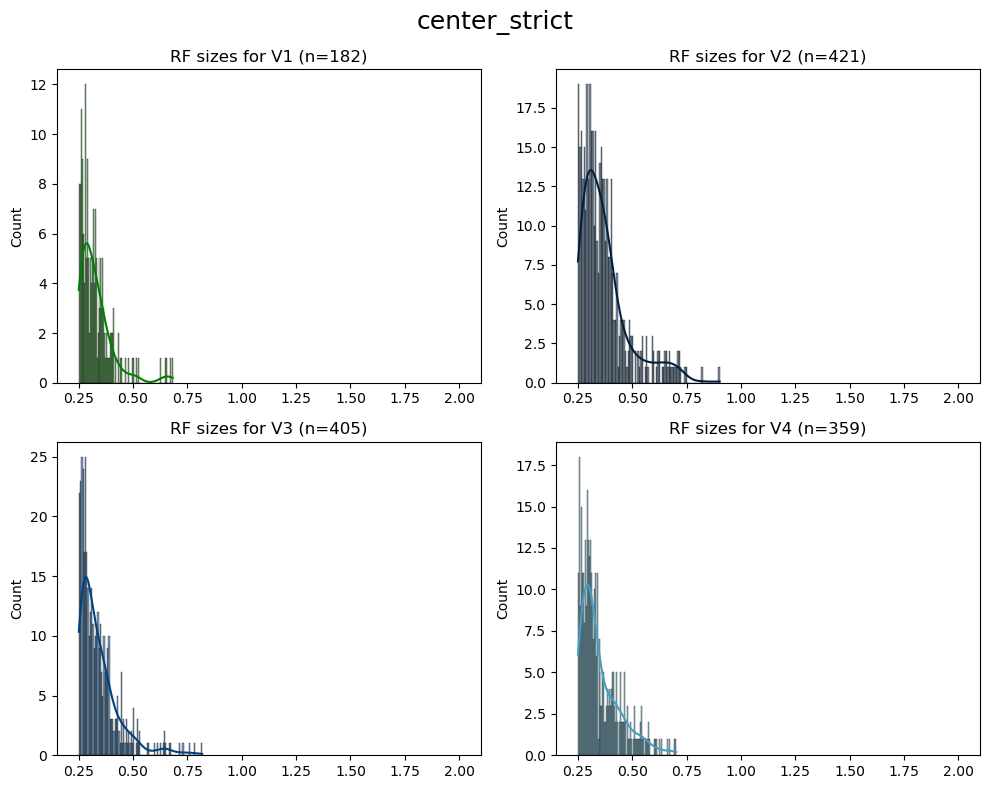

({'subj01': {'V1_mask': array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,

In [10]:
# 1 min
# hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
#                                              min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 150,plot_sizes = 'y')

hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .25, max_size = 2, prf_proc_dict = prf_dict, vox_n_cutoff = None ,plot_sizes = 'y')

prf_mask_center_strict_prf_rsq

(145, 186, 148)


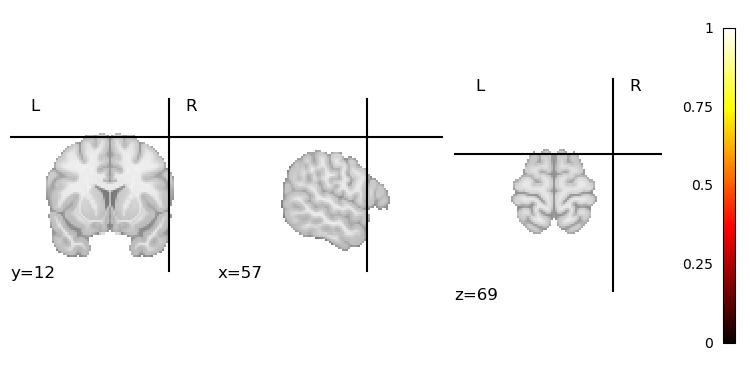

In [79]:
prfgain = prf_dict['subj01']['nsd_dat']['eccentricity']['prf_dat']
prfsok = prf_dict['subj01']['nsd_dat']['R2']['prf_dat']


print(prfgain.shape)

v1betas = hrf_dict_tight['subj01']['V1_mask']['roi_sizes'][:,:-1].astype('int')
# print(v1betas)
v1np = coords2numpy(v1betas, prfgain.shape)
    
    
v1nii = nib.Nifti1Image(v1np.astype(np.int16), affine=np.eye(4))

plotting.plot_stat_map(v1nii, display_mode = 'ortho')


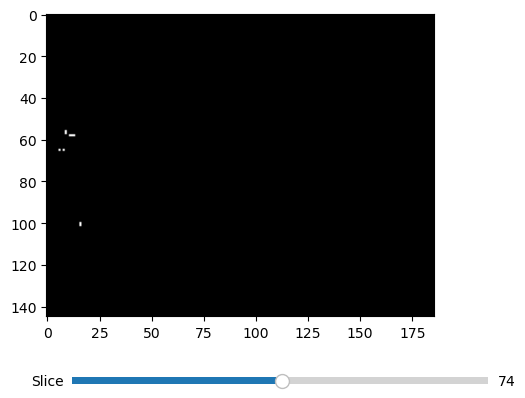

In [84]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Initial slice
init_slice = v1np.shape[2] // 2

# Create figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

# Display initial image
im = ax.imshow(v1np[:,:,init_slice], cmap="gray")

# Create slider
axslice = plt.axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(axslice, 'Slice', 0, v1np.shape[2] - 1, valinit=init_slice, valstep=1)

# Update function for slider
def update(val):
    slice = int(slider.val)
    im.set_data(v1np[:,:,slice])
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



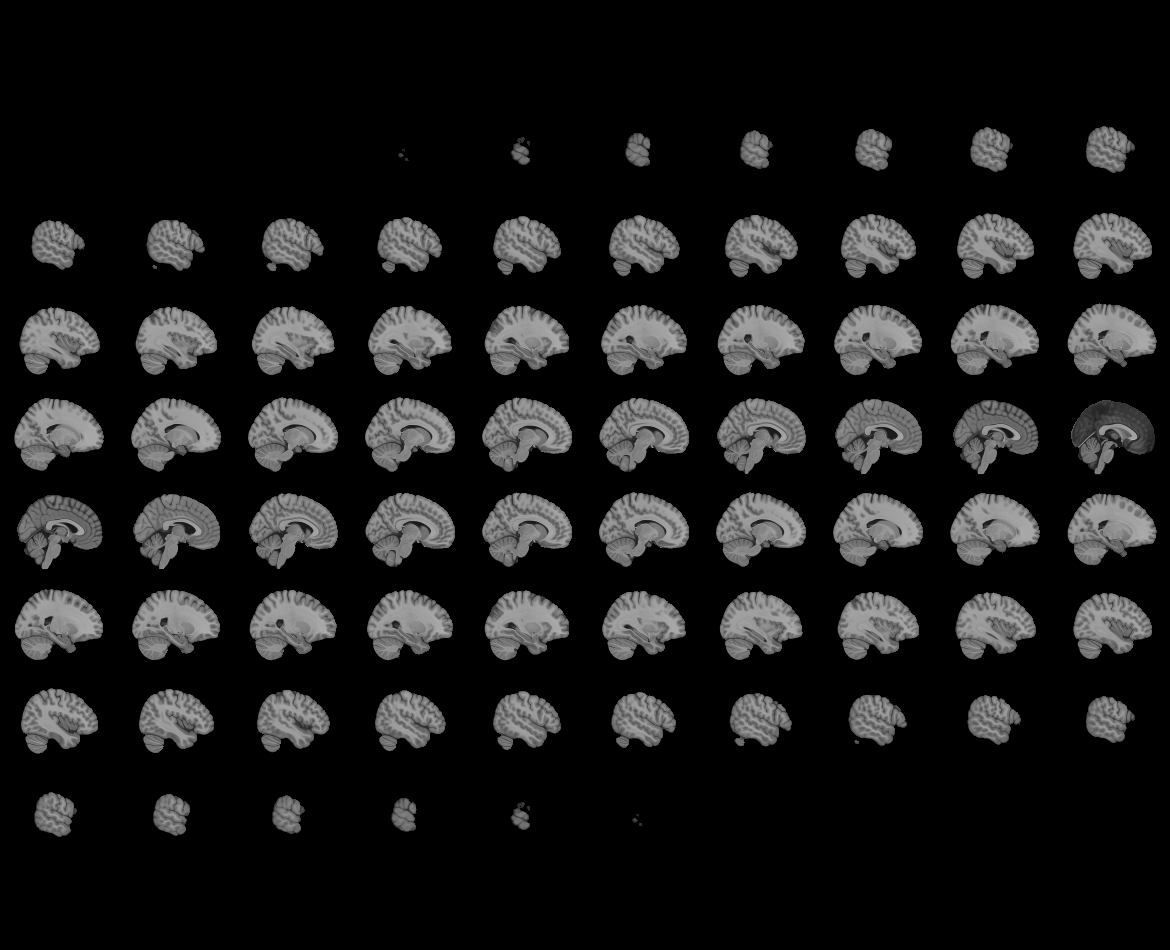
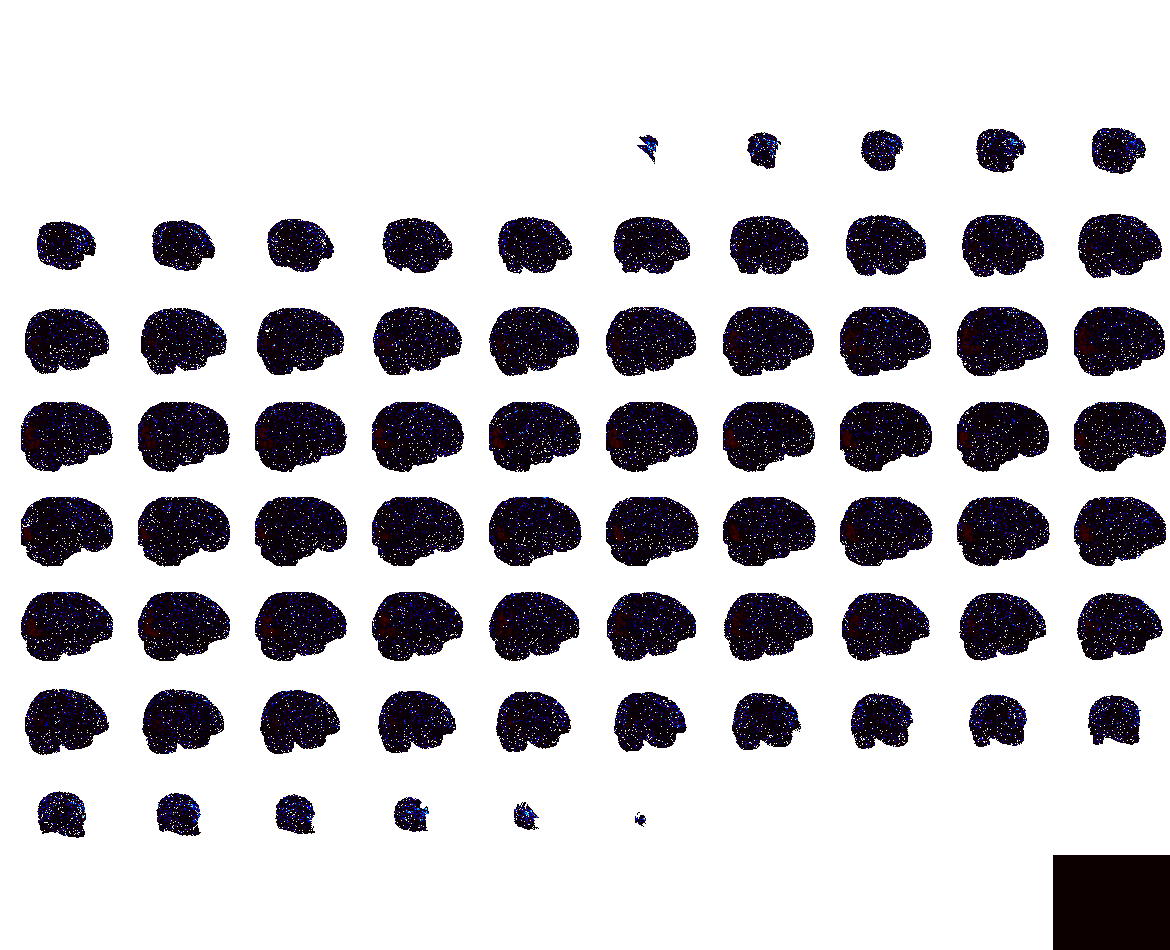

In [60]:
from nilearn import plotting
brain = vismask_dict['subj01']['V1_mask']

ni_img = nib.Nifti1Image(brain.astype(np.int16), affine=np.eye(4))
plotting.view_img(prfsok, display_mode = 'ortho')


# plotting.plot_roi(prfgain, display_mode='ortho', cut_coords=(12, 68, 60), title='V1 Mask')



In [21]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image


In [1]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
transform = transforms.Compose([
    transforms.Resize(425),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


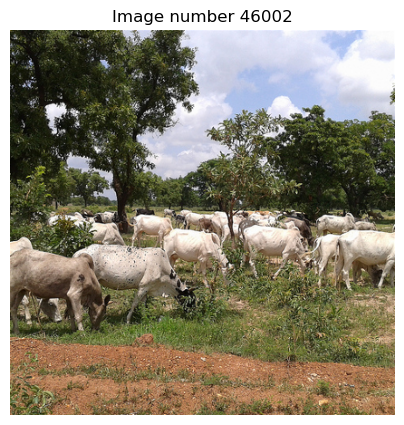

In [71]:
imgnp = show_stim(img_no = 46002, small = 'y')[0]
imgPIL = Image.fromarray(imgnp) # Convert into PIL from np
imgt = transform(imgPIL) # Transform into the right format for alexnet
img = imgt.unsqueeze(0) # add a batch dimension

In [33]:
with torch.no_grad():
    features = alexnet(img)

In [43]:
feat_np = features.numpy()

IndexError: index 6 is out of bounds for axis 0 with size 1

In [42]:
outputs = alexnet(img)
outputs[6]

IndexError: index 6 is out of bounds for dimension 0 with size 1

#################################

In [54]:
import torch.nn as nn

class AlexNetConv4(nn.Module):
    def __init__(self):
        super(AlexNetConv4, self).__init__()
        self.features = nn.Sequential(
            # stop at conv4
            *list(models.alexnet(pretrained=True).features.children())[:10]
        )
    def forward(self, x):
        x = self.features(x)
        return x

model = AlexNetConv4()
model.eval()

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNetConv4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
)

In [62]:
# Perform the forward pass
with torch.no_grad():
    img_out = model(img)

#########################################################

In [73]:
import torch
import torchvision.models as models

# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [74]:
from torch.nn import Module

class AlexNetFeatureExtractor(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:3])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[3:6])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[6:8])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[8:10])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[10:13])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5


In [87]:
from torch.nn import Module

class AlexNetFeatureExtractor(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:3])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[3:6])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[6:8])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[8:10])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[10:13])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5

feature_extractor = AlexNetFeatureExtractor(model)

#### This one works for the full 425x425 images

In [81]:
from torchvision import transforms
from PIL import Image

# Load and preprocess the image
# img = Image.open('path_to_your_image.jpg')
img = imgPIL
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize so the smallest side is 256
    transforms.CenterCrop(227),  # Crop a 227x227 patch from the center
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension


#### This is for the 100x100 crops

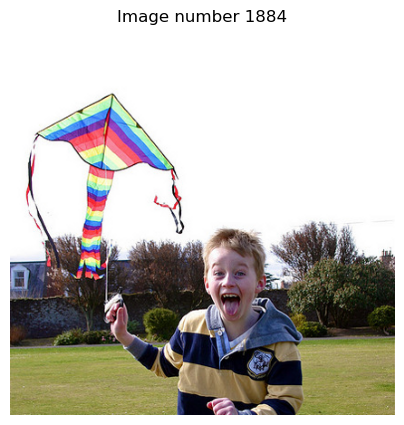

In [148]:
from torchvision import transforms
from PIL import Image

imgnp = show_stim(img_no = 1884, small = 'y')[0][163:263,163:263]
imgPIL = Image.fromarray(imgnp) # Convert into PIL from np
# imgt = transform(imgPIL) # Transform into the right format for alexnet
# img = imgt.unsqueeze(0) # add a batch dimension
# img = imgPIL
preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(imgPIL).unsqueeze(0)  # Add batch dimension


(-0.5, 99.5, 99.5, -0.5)

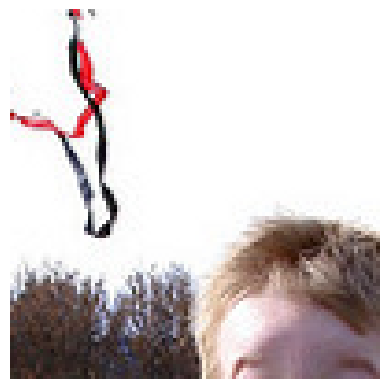

In [149]:
plt.imshow(imgnp)
plt.axis('off')

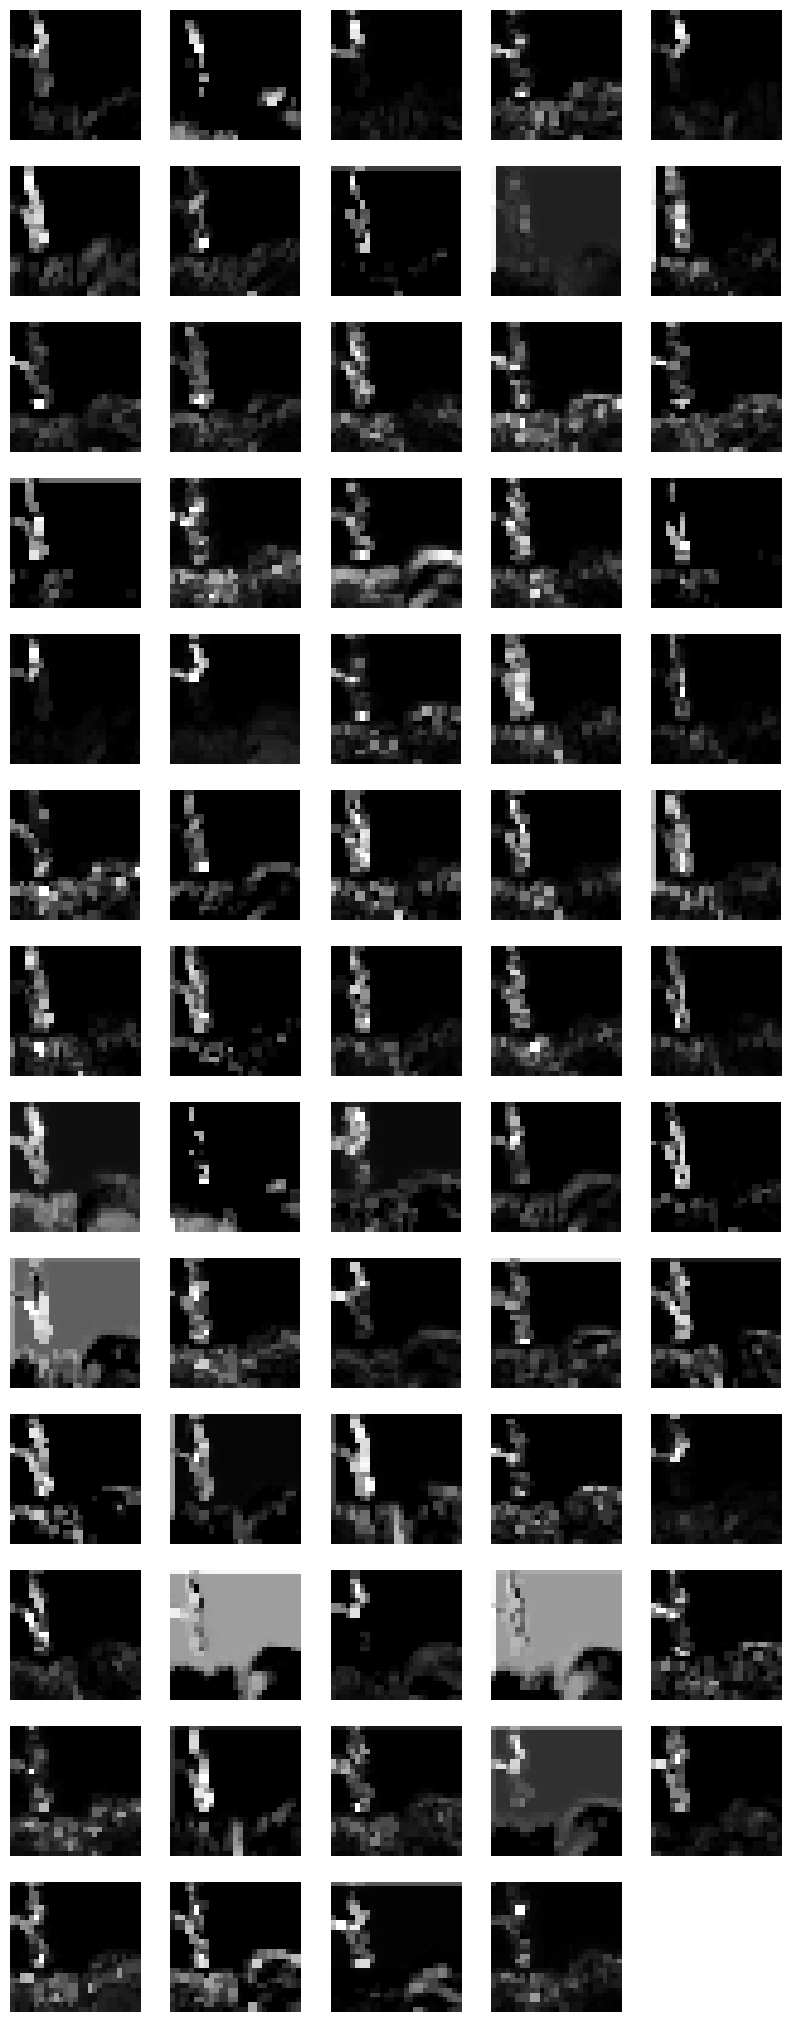

In [150]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features(features, num_cols=5):
    # Choose a single layer output to visualize
    layer_features = features[0]  # For example, visualize the first layer outputs
    num_features = layer_features.shape[1]  # Number of channels in the selected layer

    num_rows = (num_features + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_features:
            # Normalize feature map for better visualization
            feature_map = layer_features[0, i].detach().numpy()
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            ax.imshow(feature_map, cmap='grey')
        ax.axis('off')

    plt.show()

# Assuming you have initialized and passed the image through the feature_extractor
features = feature_extractor(img_tensor)
plot_features(features)


#########################################

In [151]:
import torch
import torchvision.models as models

# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet.eval()


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

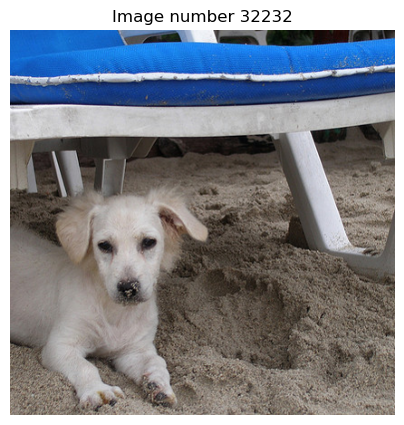

In [153]:
from torchvision import transforms
from PIL import Image

# Define the image transformation
preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your image
img = Image.fromarray(show_stim(small = 'y')[0])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension


In [154]:
from torch import nn

class AlexNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        self.features = model.features
        self.avgpool = model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Initialize the feature extractor
feature_extractor = AlexNetFeatureExtractor(alexnet)

# Extract features
features = feature_extractor(img_tensor)


In [277]:
from funcs.imgproc import rand_img_list

n_imgs = 1000
imgs, _,_ = rand_img_list(n_imgs, asPIL = True, add_masks = False, select_ices = get_imgs_designmx()[0]['subj01'][:n_imgs])



def get_alexnet_features(imgs):
    
    # Load your image
    # img = Image.fromarray(show_stim(small = 'y')[0])
    for n, img in enumerate(imgs):
        print(n)
        img_tensor = preprocess(img).unsqueeze(0) # Add batch dimension
        features = feature_extractor(img_tensor)
        print(features)
        if n == 0:
            all_feats = np.zeros((features.shape[1], len(imgs)))
        all_feats[:,n] = features.detach().numpy()
    return all_feats


In [278]:
ft = get_alexnet_features(imgs)

0
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
2
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.8388, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
3
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
4
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.4172, 2.1806]],
       grad_fn=<ViewBackward0>)
5
tensor([[2.9288, 2.9288, 0.0000,  ..., 1.3005, 0.7588, 0.0000]],
       grad_fn=<ViewBackward0>)
6
tensor([[ 0.0000,  0.0000,  0.0000,  ..., 11.4147, 14.3312, 14.3312]],
       grad_fn=<ViewBackward0>)
7
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
8
tensor([[0.0000, 0.0000, 1.1892,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
9
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1764, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
10
tensor([[0.0000, 0.0000, 0.0000,  ..., 2.7925, 2.7925, 0.0000]],
       grad_fn=<ViewBackward0>)
11
tensor([[0.0000, 0.0000, 

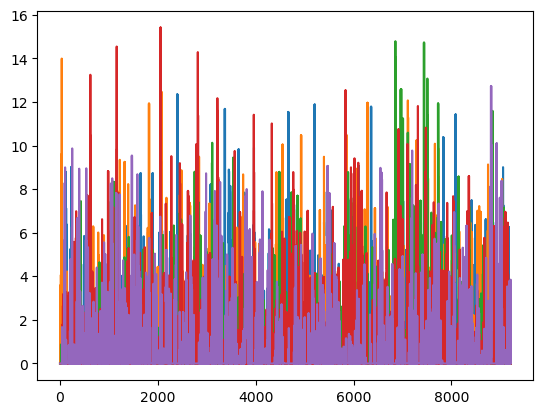

In [268]:
plt.plot(ft[:,0])
plt.plot(ft[:,1])
plt.plot(ft[:,2])
plt.plot(ft[:,3])
plt.plot(ft[:,4])

In [279]:
def get_beta_selection(subject = 'subj01', roi = 'V1_mask', n_voxels = 10, n_imgs = 1000, hrf_dict = None):
    vox_ids = list(hrf_dict[subject][roi].keys())
    y = np.zeros((n_imgs, n_voxels))
    for vox in range(n_voxels):
        vox_id = vox_ids[vox]
        
        y[:,vox] = hrf_dict[subject][roi][vox_id]['hrf_betas'][:n_imgs]
        
        
    return y
# hrf_dict_tight['subj01']['V1_mask']['voxel1']['hrf_betas'].shape

bets = get_beta_selection(subject = 'subj01', roi = 'V1_mask', n_voxels = 10, n_imgs = 1000, hrf_dict = hrf_dict_tight)

In [280]:
bets.shape

(1000, 10)

In [281]:
if ft.shape[0] != n_imgs:
    ft = ft.T
ft.shape


(1000, 9216)

In [312]:
from sklearn.cross_decomposition import PLSRegression

# Assuming 'features' is a matrix of features from your images
# and 'betas' is a matrix of HRF betas from your fMRI dataset
pls = PLSRegression(n_components=40)
pls.fit(ft, bets)
# pls.fit(features.numpy(), betas)


# You can now use pls to predict, analyze coefficients, etc.


PLSRegression(n_components=40)

In [313]:
coefficients = pls.coef_


In [314]:
def calculate_vip(model):
    t = model.x_scores_  # Scores
    w = model.x_weights_  # Weights
    q = model.y_loadings_  # Loadings

    p, h = w.shape
    vips = np.zeros((p,))
    
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)
    
    return vips

vip_scores = calculate_vip(pls)
print(vip_scores)

/tmp/ipykernel_1392743/2121012377.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p * (s.T @ weight) / total_s)


[0.83146 0.93539 0.9973  ... 0.94199 0.83427 0.99998]


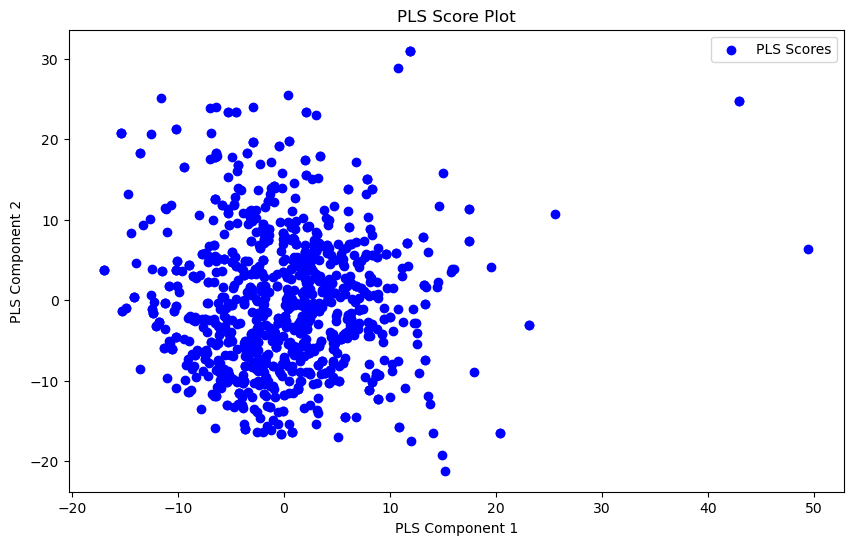

In [315]:
import matplotlib.pyplot as plt

# Plotting the scores
plt.figure(figsize=(10, 6))
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1], c='blue', label='PLS Scores')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Score Plot')
plt.legend()
plt.show()


In [316]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Cross-validation predictions
y_cv = cross_val_predict(pls, ft, bets, cv=5)

# Calculate metrics
mse = mean_squared_error(bets, y_cv)
r2 = r2_score(bets, y_cv)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


MSE: 0.8265774276660613
R^2: -0.5378423121725813


In [317]:
n_imgs = 1000
# start = n_imgs + random.randint(0,72999-n_imgs)
start = 1500
new_imgs, _,_ = rand_img_list(n_imgs, asPIL = True, add_masks = False, select_ices = get_imgs_designmx()[0]['subj01'][start:n_imgs+start])

new_features = get_alexnet_features(new_imgs).T

0
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
2
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
3
tensor([[0.6502, 1.1730, 4.4353,  ..., 0.0000, 0.0000, 5.9249]],
       grad_fn=<ViewBackward0>)
4
tensor([[0.0000, 0.0000, 1.9403,  ..., 2.0747, 0.9660, 2.0726]],
       grad_fn=<ViewBackward0>)
5
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
6
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
7
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
8
tensor([[0.0000, 0.5696, 1.6297,  ..., 0.0000, 1.2088, 0.9843]],
       grad_fn=<ViewBackward0>)
9
tensor([[6.6789, 5.6626, 7.2251,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
10
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
11
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
12
tensor([[1.2549, 5.4822, 8.3650,  ..., 0.0000, 0.0000, 

In [318]:
if new_features.shape[0] != n_imgs:
    new_features = new_features.T
new_features.shape
# Predicting new data (assuming 'new_features' is your new dataset)
new_betas_predicted = pls.predict(new_features)


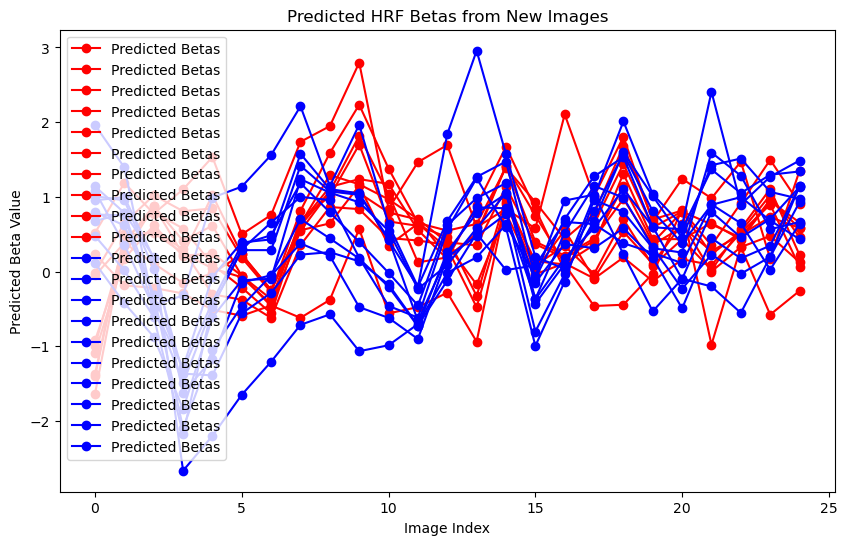

In [324]:
import matplotlib.pyplot as plt

# Example: Plotting the predicted beta values
plt.figure(figsize=(10, 6))
plt.plot(new_betas_predicted[100:125], 'ro-', label='Predicted Betas')
plt.plot(bets[100:125], 'bo-', label='Predicted Betas')
plt.title('Predicted HRF Betas from New Images')
plt.xlabel('Image Index')
plt.ylabel('Predicted Beta Value')
plt.legend()
plt.show()


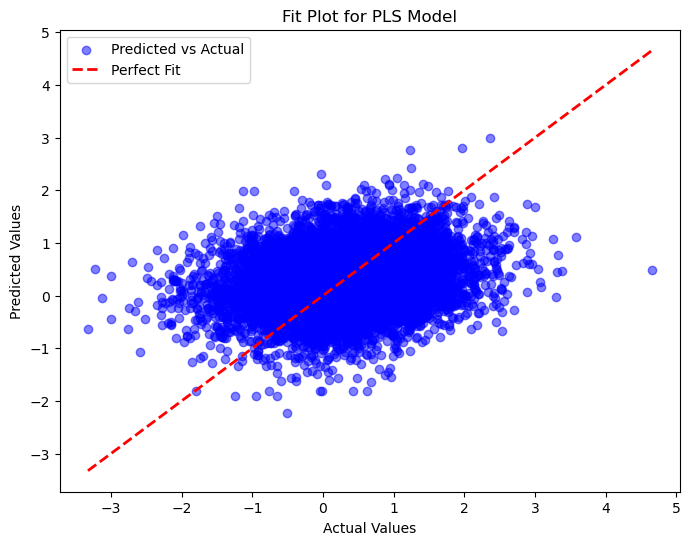

In [323]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'actual_values' and 'predicted_values' are your datasets
actual_values = bets  # This should be your actual data
# predicted_values = pls.predict(features.numpy())  # Predict using your PLS model
predicted_values = pls.predict(new_features)
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.title('Fit Plot for PLS Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot a line of perfect fit
line = np.linspace(min(actual_values.min(), predicted_values.min()), max(actual_values.max(), predicted_values.max()), 100)
plt.plot(line, line, color='red', linewidth=2, linestyle='--', label='Perfect Fit')

plt.legend()
plt.show()


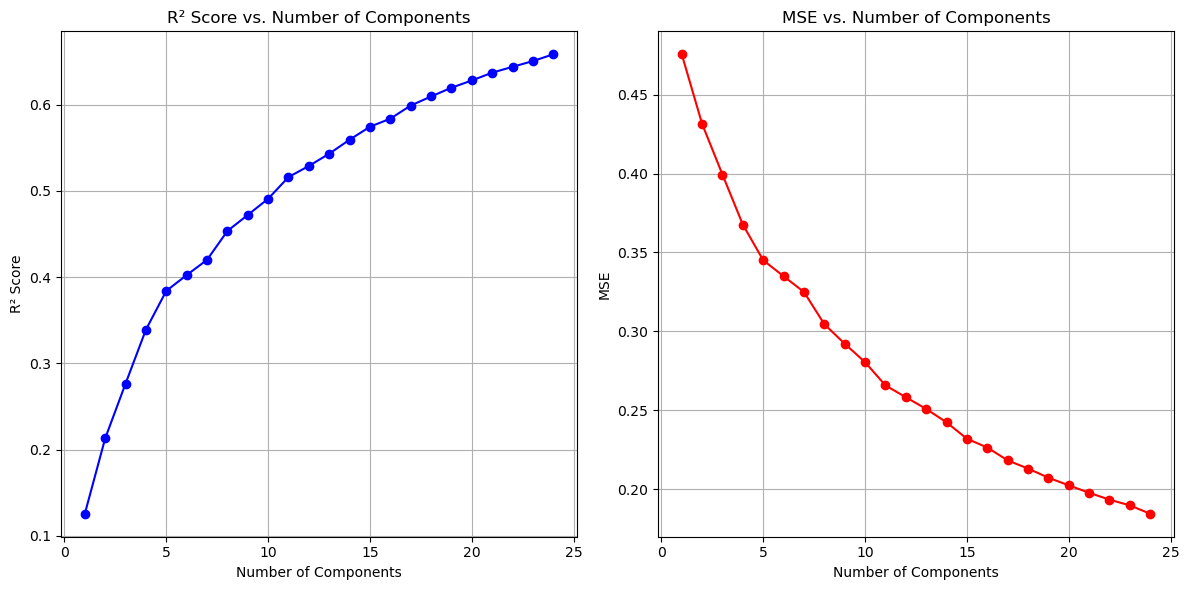

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'features' and 'betas' are your datasets
# X = features.numpy()  # Convert to numpy if not already
X = ft
Y = bets

# Lists to store the metrics
r2_scores = []
mse_scores = []
component_range = range(1, 25)  # Adjust the range based on your dataset and needs

for n_components in component_range:
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    Y_pred = pls.predict(X)
    
    # Calculate metrics
    r2 = r2_score(Y, Y_pred)
    mse = mean_squared_error(Y, Y_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(component_range, r2_scores, marker='o', linestyle='-', color='b')
plt.title('R² Score vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(component_range, mse_scores, marker='o', linestyle='-', color='r')
plt.title('MSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()
